In [1]:
path = r'C:/Users/ruw/Desktop'
import sys # https://stackoverflow.com/questions/4383571/importing-files-from-different-folder
sys.path.insert(1, rf'{path}\RA\penicilin\Libaries')

In [ ]:
import standards as s


import bw2data as bd
import bw2calc as bc
import pandas as pd

import matplotlib.pyplot as plt


import standards as s


In [3]:
matching_database = "ev391cutoff"
database = "penicillin_cut_off"

In [4]:
from lca import LCA

lca_init = LCA(path=path, matching_database=matching_database)


In [38]:
func_unit_recycling = {}
for act in lca_init.db:
    # print(act)
    if "Penicillin G," in act["name"]:
        func_unit_recycling[act["name"]] = []
        for exc in act.exchanges():
            if "incineration" in exc["name"] or "recycled" in exc["name"]:
                func_unit_recycling[act["name"]].append({exc.input : exc["amount"]})
            elif "Penicillin G," in exc["name"]:
                func_unit_recycling[act["name"]].append({exc.input : exc["amount"]})



In [37]:
fu_keys_sorted = list(func_unit_recycling.keys())
fu_keys_sorted.sort()
fu_keys_sorted

func_unit_recycling_sorted = {}

for key in fu_keys_sorted:
    func_unit_recycling_sorted[key] = func_unit_recycling[key]



In [8]:
ics = lca_init.lcia_impact_method()     
pen_arr = []           
# Set up and perform the LCA calculation
for scenario, fu in func_unit_recycling_sorted.items():
    bd.calculation_setups[str(scenario)] = {'inv': fu, 'ia': [ics[1]]}
        
    mylca = bc.MultiLCA(str(scenario))
    res = mylca.results
    pen_arr.append(res)

In [ ]:
res_countries_dct = {}
for lst_idx, (scenario, fu) in enumerate(func_unit_recycling_sorted.items()):
    res_countries_dct[scenario] = {}
    for arr_idx, dct in enumerate(fu):
        temp = {}
        for act in dct.keys():  
            val = pen_arr[lst_idx][arr_idx][0]
            if arr_idx == 0:
                act_0 = act
                val_0 = val
                temp[act_0] = val_0
            else:
                val_0 -= val
                temp[act_0] = val_0
                temp[act] =  val
            res_countries_dct[scenario].update(temp)
res_countries_dct

1
1
2
1
2
1
2


{'Penicillin G, defined system': {'Penicillin G, defined system' (unit, DK, None): 0.6677475851154853,
  'treatment of hazardous waste, hazardous waste incineration, with energy recovery' (kilogram, CH, None): 0.28653211101641424},
 'Penicillin G, recycling': {'Penicillin G, recycling' (unit, DK, None): 0.6677475886721023,
  'treatment of hazardous waste, hazardous waste incineration, with energy recovery' (kilogram, CH, None): 0.024296576540976403,
  'market for polyethylene, high density, granulate, recycled' (kilogram, Europe without Switzerland, None): 0.0764575276531738},
 'Penicillin G, recycling IV': {'Penicillin G, recycling IV' (unit, DK, None): 0.6677475900466566,
  'treatment of hazardous waste, hazardous waste incineration, with energy recovery' (kilogram, CH, None): 0.12055444319151334,
  'market for polyethylene, high density, granulate, recycled' (kilogram, Europe without Switzerland, None): 0.04839253447825693},
 'Penicillin G, recycling gloves': {'Penicillin G, recycli

In [ ]:
idx_lst = [
    "Other",
    "Incineration",
    "Recycled"
]

df = pd.DataFrame(0, index=idx_lst, columns=res_countries_dct.keys(), dtype=object)

for scenario in df.columns:
    print(scenario)
    for idx, row in df.iterrows():
        for act, val in res_countries_dct[scenario].items():
            if idx.lower() in str(act):
                row[scenario] = val
                # print(idx, act)
                # else:
                #     print(idx, key)
            elif "Penicillin G" in str(act) and idx_lst[-1] not in idx:
                row[scenario] = val
            # else:
            #     row[scenario] = val

excel_path = s.join_path(lca_init.path_github, r"results\sensitivity\sens_eol_penG.xlsx")

s.save_LCIA_results(df,file_name=excel_path, sheet_name="EoL")

Penicillin G, defined system
'Penicillin G, defined system' (unit, DK, None) Other
'Penicillin G, defined system' (unit, DK, None) Incineration
Penicillin G, recycling
'Penicillin G, recycling' (unit, DK, None) Other
'Penicillin G, recycling' (unit, DK, None) Incineration
Penicillin G, recycling IV
'Penicillin G, recycling IV' (unit, DK, None) Other
'Penicillin G, recycling IV' (unit, DK, None) Incineration
Penicillin G, recycling gloves
'Penicillin G, recycling gloves' (unit, DK, None) Other
'Penicillin G, recycling gloves' (unit, DK, None) Incineration


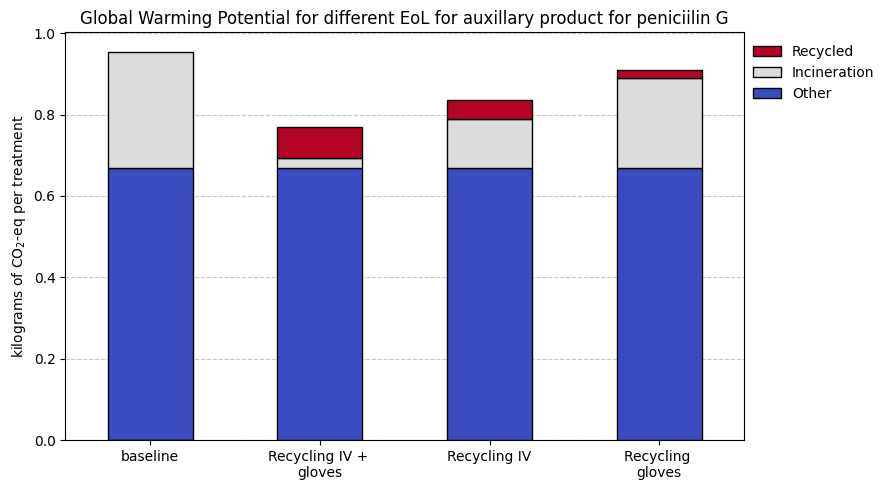

In [35]:
width = 0.5

# func_unit, elec_val_G, elec_val_V = create_func_unit()

# df_res_dct = results_sorting(func_unit, elec_val_V, elec_val_G, calc)

plot_save_path = s.join_path(lca_init.path_github, r"results\figures")


colors = s.color_range(colorname="coolwarm", color_quantity=len(df.index))
fig, ax = plt.subplots(figsize=(9, 5))
df.T.plot(
    kind='bar',
    stacked=True,
    title="Global Warming Potential for different EoL for auxillary product for peniciilin G",
    color=colors,
    ax=ax,
    width=width,
    edgecolor="k",
    zorder=10
)

leg_color, _ = fig.gca().get_legend_handles_labels()
leg_txt = list(df.index)
# if "V" in pen_type[p]:
#     leg_txt.pop(-2)
#     leg_color.pop(-2)
    
# Reverse the order of handles and labels
leg_txt = leg_txt[::-1]
leg_color = leg_color[::-1]

ax.legend(
        leg_color,
        leg_txt,
        loc='upper left',
        bbox_to_anchor=(0.995, 1),
        ncol= 1,  # Adactjust the number of columns based on legend size
        fontsize=10,
        frameon=False
    )
# ax.set_title(f"Global Warming Potential for 1 treatment of penicillin {pen_type[p]}")
ax.set_ylabel('kilograms of CO$_2$-eq per treatment')

xtick_txt = [
    "baseline",
    "Recycling IV + \ngloves",
    "Recycling IV",
    "Recycling \ngloves",
]


ax.set_xticklabels(xtick_txt, rotation=0)
ax.grid(axis='y', linestyle='--', alpha=0.7, zorder=-0)
plt.tight_layout()
# output_file = s.join_path(plot_save_path, f"pen{pen_type[p]}_countries_sens.png")
# plt.savefig(output_file, dpi=300, format='png', bbox_inches='tight')
plt.show()